# Analisis Kadar Amonium dalam Air Menggunakan Model Regresi Machine Learning Berdasarkan Parameter Kualitas Air

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [41]:
# Load dataset
data = pd.read_csv("water2.csv")

In [42]:
print('****'*10)
print(f'Dataframe has {data.shape[0]} Rows, {data.shape[1]} Columns')
print('****'*10)
#menampilkan 5 data teratas
data.head()

****************************************
Dataframe has 337 Rows, 5 Columns
****************************************


,pH,Conductivity (mS/m),Turbidity (NTU),Colour (TCU),Ammonium (mg/L)
0,8.13,49.4,5.0,24.0,0.276
1,8.07,53.7,5.0,22.0,0.244
2,8.16,56.2,3.0,25.0,0.234
3,8.34,57.0,5.0,24.0,0.190
4,8.35,59.8,9.0,26.0,0.207


In [43]:
# Cek apakah ada missing values
print(data.isnull().sum())


pH                     0
Conductivity (mS/m)    0
Turbidity (NTU)        0
Colour (TCU)           0
Ammonium (mg/L)        0
dtype: int64


## Ekplorasi Data Analisis (EDA)

In [44]:
# Cek tipe data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pH                   337 non-null    float64
 1   Conductivity (mS/m)  337 non-null    float64
 2   Turbidity (NTU)      337 non-null    float64
 3   Colour (TCU)         337 non-null    float64
 4   Ammonium (mg/L)      337 non-null    float64
dtypes: float64(5)
memory usage: 13.3 KB


In [45]:
# Statistik Deskriptif dengan pembatasan angka di belakang koma
data.describe().round(2)

,pH,Conductivity (mS/m),Turbidity (NTU),Colour (TCU),Ammonium (mg/L)
count,337.00,337.00,337.00,337.00,337.00
mean,7.96,46.96,20.87,78.27,0.73
std,0.68,14.92,30.97,146.24,3.17
min,2.41,0.21,0.74,-2.00,-0.02
25%,7.57,36.80,4.41,26.75,0.09
50%,8.03,46.73,10.09,34.00,0.23
75%,8.35,54.00,25.48,64.00,0.55
max,9.69,161.50,234.80,1524.00,55.33


In [46]:
#cek jumlah total data masing-masing variabel
data.count()

pH                     337
Conductivity (mS/m)    337
Turbidity (NTU)        337
Colour (TCU)           337
Ammonium (mg/L)        337
dtype: int64

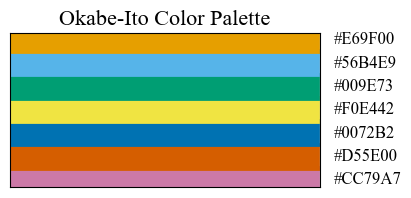

In [47]:
# Definisikan palet warna Okabe-Ito
okabe_ito_colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

# Balikkan urutan warna
okabe_ito_colors_reversed = okabe_ito_colors[::-1]

# Visualisasi palet warna Okabe-Ito dengan urutan terbalik
plt.figure(figsize=(4, 2))
for i, color in enumerate(okabe_ito_colors_reversed):
    plt.plot([0, 1], [i, i], color=color, linewidth=20)
    plt.text(1.1, i, color, fontsize=12, verticalalignment='center', fontname="Times New Roman")
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.title("Okabe-Ito Color Palette", fontname="Times New Roman", fontsize=16)
plt.show()

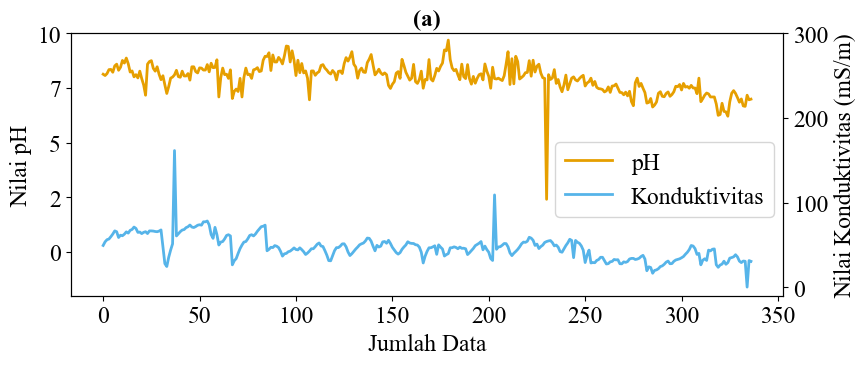

In [48]:
def plot_mirror(data, x_label="Jumlah Data", y_label_left="Nilai pH", y_label_right="Nilai Konduktivitas (mS/m)", 
                title="(a)", fontname="Times New Roman", fontsize=16, 
                pH_range=None, conductivity_range=None, legend_loc="upper left"):
    """
    Membuat grafik line dengan metode mirror untuk variabel pH dan Konduktivitas.

    Parameters:
    - data (pd.DataFrame): Dataframe yang berisi data pH dan Konduktivitas.
    - x_label (str): Label untuk sumbu x.
    - y_label_left (str): Label untuk sumbu y di sebelah kiri.
    - y_label_right (str): Label untuk sumbu y di sebelah kanan.
    - title (str): Judul grafik.
    - fontname (str): Nama font yang digunakan.
    - fontsize (int): Ukuran font.
    - pH_range (tuple): Rentang nilai untuk sumbu y (pH).
    - conductivity_range (tuple): Rentang nilai untuk sumbu y (Konduktivitas).
    - legend_loc (str): Lokasi legend pada plot.
    """
    fig, ax1 = plt.subplots(figsize=(9, 4), dpi=100)

    # Plot data pH (bagian bawah)
    line1, = ax1.plot(data.index, -data['pH'], color=okabe_ito_colors[0], linewidth=2, label="pH")
    ax1.set_xlabel(x_label, fontname=fontname, fontsize=fontsize)
    ax1.set_ylabel(y_label_left, fontname=fontname, fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.set_ylim(pH_range if pH_range else (-data['pH'].max() - 1, -data['pH'].min() + 1))
    #ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{-x:.1f}"))  # Mirror axis dengan koma
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{-int(x)}"))  # Mirror axis tanpa koma

    # Plot data Konduktivitas (bagian atas)
    ax2 = ax1.twinx()
    line2, = ax2.plot(data.index, data['Conductivity (mS/m)'], color=okabe_ito_colors[1], linewidth=2, label="Konduktivitas")
    ax2.set_ylabel(y_label_right, fontname=fontname, fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.set_ylim(conductivity_range if conductivity_range else (data['Conductivity (mS/m)'].min() - 5, 
                                                                data['Conductivity (mS/m)'].max() + 5))

    # Tambahkan grid
    #ax1.grid(linestyle='--', alpha=0.7)

    # Tambahkan judul
    plt.title(title, fontname=fontname, fontsize=fontsize, fontweight='bold')

    # Tambahkan legend
    plt.legend([line1, line2], ["pH", "Konduktivitas"], loc=legend_loc, fontsize=fontsize)

    # Tampilkan plot
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
plot_mirror(data, pH_range=(2, -10), conductivity_range=(-10, 300), fontsize=17, legend_loc=(0.68, 0.3))

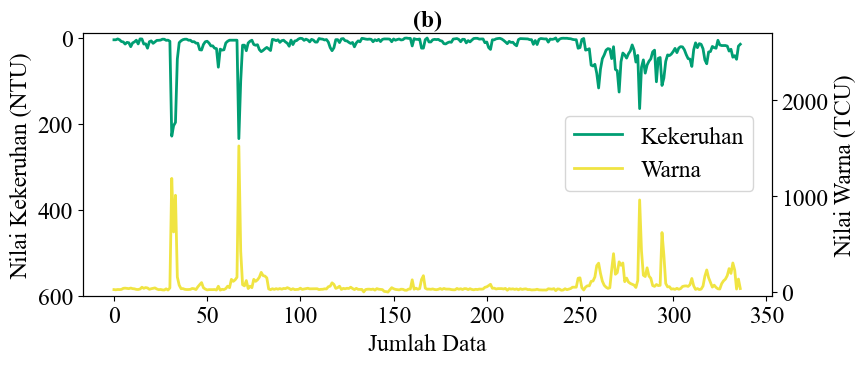

In [49]:
def plot_mirror(data, x_label="Jumlah Data", y_label_left="Nilai Kekeruhan (NTU)", y_label_right="Nilai Warna (TCU)", 
                title="(b)", fontname="Times New Roman", fontsize=16, 
                turbidity_range=None, color_range=None, legend_loc="upper left"):
    """
    Membuat grafik line dengan metode mirror untuk variabel Kekeruhan dan Warna.

    Parameters:
    - data (pd.DataFrame): Dataframe yang berisi data Kekeruhan dan Warna.
    - x_label (str): Label untuk sumbu x.
    - y_label_left (str): Label untuk sumbu y di sebelah kiri.
    - y_label_right (str): Label untuk sumbu y di sebelah kanan.
    - title (str): Judul grafik.
    - fontname (str): Nama font yang digunakan.
    - fontsize (int): Ukuran font.
    - turbidity_range (tuple): Rentang nilai untuk sumbu y (Kekeruhan).
    - color_range (tuple): Rentang nilai untuk sumbu y (Warna).
    - legend_loc (str): Lokasi legend pada plot.
    """
    fig, ax1 = plt.subplots(figsize=(9, 4), dpi=100)

    # Plot data Kekeruhan (bagian bawah)
    line1, = ax1.plot(data.index, -data['Turbidity (NTU)'], color=okabe_ito_colors[2], linewidth=2, label="Kekeruhan")
    ax1.set_xlabel(x_label, fontname=fontname, fontsize=fontsize)
    ax1.set_ylabel(y_label_left, fontname=fontname, fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.set_ylim(turbidity_range if turbidity_range else (-data['Turbidity (NTU)'].max() - 5, -data['Turbidity (NTU)'].min() + 5))
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{-int(x)}"))  # Mirror axis tanpa koma

    # Plot data Warna (bagian atas)
    ax2 = ax1.twinx()
    line2, = ax2.plot(data.index, data['Colour (TCU)'], color=okabe_ito_colors[3], linewidth=2, label="Warna")
    ax2.set_ylabel(y_label_right, fontname=fontname, fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.set_ylim(color_range if color_range else (data['Colour (TCU)'].min() - 10, data['Colour (TCU)'].max() + 10))

    # Tambahkan grid
    #ax1.grid(linestyle='--', alpha=0.7)

    # Tambahkan judul
    plt.title(title, fontname=fontname, fontsize=fontsize, fontweight='bold')

    # Tambahkan legend
    plt.legend([line1, line2], ["Kekeruhan", "Warna"], loc=legend_loc, fontsize=fontsize)

    # Tampilkan plot
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
plot_mirror(data, turbidity_range=(-600, 10), color_range=(-40, 2700), fontsize=17, legend_loc=(0.7, 0.4))


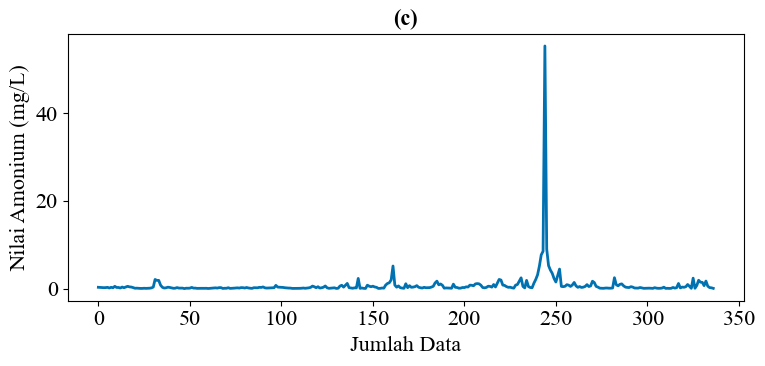

In [50]:
# Membuat grafik garis untuk data Amonium
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(data.index, data['Ammonium (mg/L)'], color=okabe_ito_colors[4], linewidth=2, label="Amonium (mg/L)")

# Menambahkan label dan judul
plt.xlabel("Jumlah Data", fontname="Times New Roman", fontsize=16)
plt.ylabel("Nilai Amonium (mg/L)", fontname="Times New Roman", fontsize=16)
plt.title("(c)", fontname="Times New Roman", fontsize=16, fontweight='bold')

# Menambahkan legenda
#plt.legend(fontsize=14, loc='upper left', frameon=True)

# Styling tick labels
plt.xticks(fontsize=16, fontname="Times New Roman")
plt.yticks(fontsize=16, fontname="Times New Roman")

# Menampilkan grid
#plt.grid(linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()


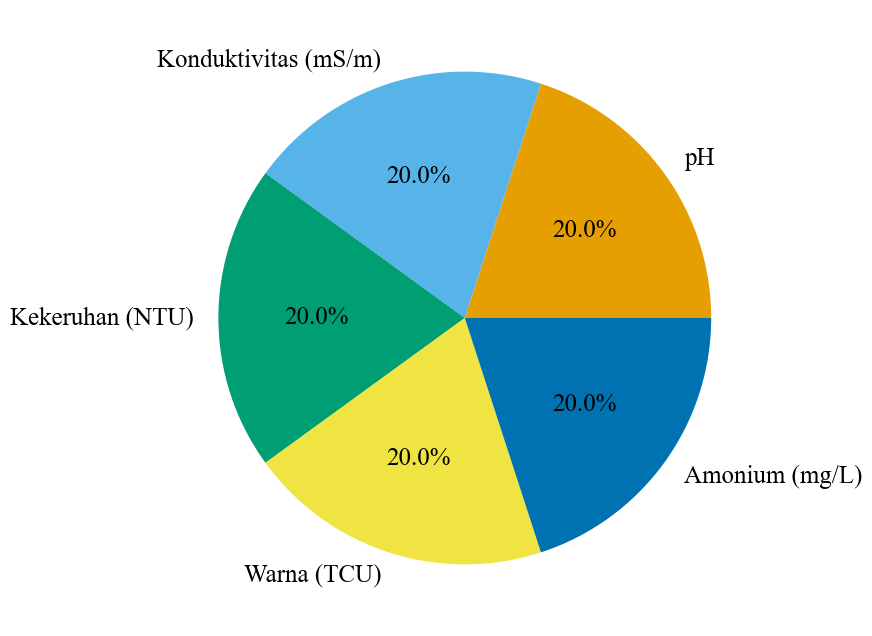

In [51]:
# Menghitung jumlah data pada setiap variabel
data_count = data.count()

# Membuat dictionary untuk menerjemahkan nama variabel ke bahasa Indonesia
variable_translation = {
    'pH': 'pH',
    'Conductivity (mS/m)': 'Konduktivitas (mS/m)',
    'Turbidity (NTU)': 'Kekeruhan (NTU)',
    'Colour (TCU)': 'Warna (TCU)',
    'Ammonium (mg/L)': 'Amonium (mg/L)'
}

# Menerjemahkan nama variabel
translated_labels = [variable_translation[var] for var in data_count.index]

# Membuat pie chart dengan warna Okabe-Ito
plt.figure(figsize=(8, 8))
plt.pie(data_count, labels=translated_labels, autopct='%1.1f%%', colors=okabe_ito_colors)

# Mengatur font ke Times New Roman dan ukuran font menjadi 18
plt.rc('font', family='Times New Roman', size=18)
#plt.title('Jumlah Data pada Setiap Variabel', fontname='Times New Roman', fontsize=12)
plt.show()

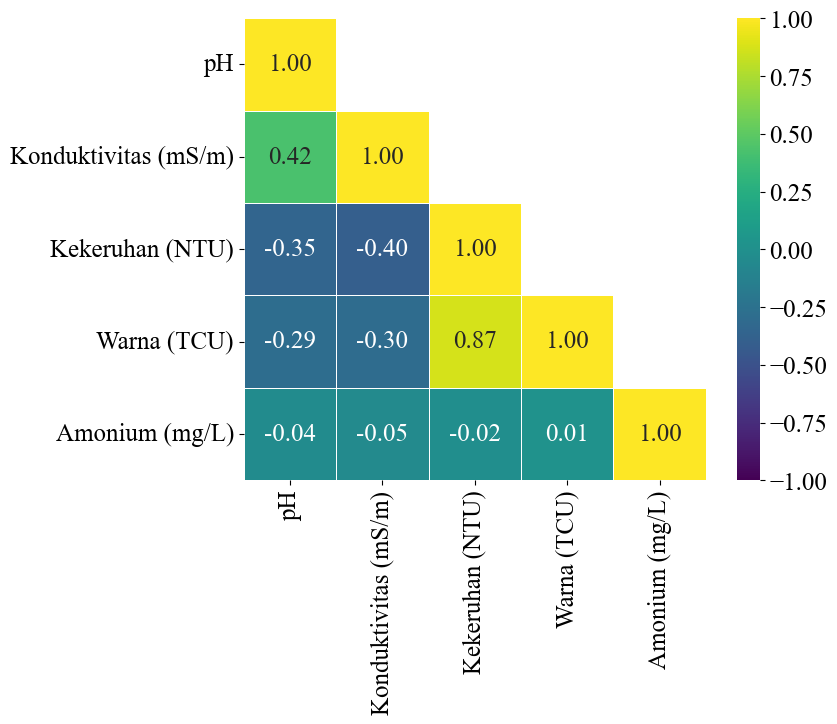

In [52]:
# Hitung korelasi
corr_matrix = data.corr()

# Ubah nama kolom dan indeks ke dalam bahasa Indonesia
corr_matrix.rename(columns=variable_translation, index=variable_translation, inplace=True)

# Buat mask untuk segitiga atas (tidak termasuk diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Plot heatmap dengan mask
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap=sns.color_palette("viridis", as_cmap=True), 
            fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, square=True,  # Tambahkan square=True
            cbar_kws={'shrink': 1}, annot_kws={"fontsize": 18, "fontfamily": "Times New Roman"})

# Atur label sumbu
plt.xticks(fontsize=18, fontname="Times New Roman")
plt.yticks(fontsize=18, fontname="Times New Roman")
plt.show()

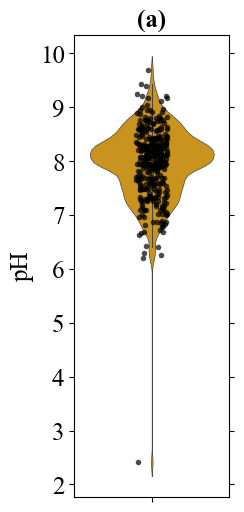

In [53]:
# Plot violin plot dengan pengaturan lebar kotak
plt.figure(figsize=(2, 6))
sns.violinplot(y=data['pH'], color=okabe_ito_colors[0], linewidth=0.5, bw_adjust=0.6, width=0.8)  # Atur lebar kotak dengan 'width'

# Tambahkan strip plot untuk menampilkan sebaran titik-titik data
sns.stripplot(y=data['pH'], color='black', alpha=0.7, jitter=True, size=4)

plt.gca().yaxis.set_ticks_position('both')  # Menampilkan ticker di kedua sisi
plt.gca().tick_params(labelright=False)  # Menonaktifkan label angka di sisi kanan

# Menambahkan label dan judul
plt.ylabel("pH", fontname="Times New Roman", fontsize=18)
plt.title("(a)", fontname="Times New Roman", fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontname="Times New Roman")
plt.show()

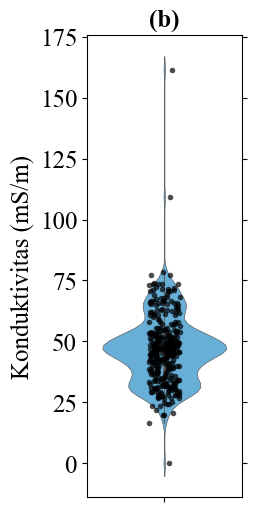

In [54]:
# Plot violin plot untuk variabel Conductivity (mS/m) dalam orientasi vertikal
plt.figure(figsize=(2, 6))
sns.violinplot(y=data['Conductivity (mS/m)'], color=okabe_ito_colors[1], linewidth=0.5, bw_adjust=0.6, width=0.8)

# Tambahkan strip plot untuk menampilkan sebaran titik-titik data
sns.stripplot(y=data['Conductivity (mS/m)'], color='black', alpha=0.7, jitter=True, size=4)

# Menampilkan ticker di kedua sisi
plt.gca().yaxis.set_ticks_position('both')
plt.gca().tick_params(labelright=False)

# Menambahkan label dan judul
plt.ylabel("Konduktivitas (mS/m)", fontname="Times New Roman", fontsize=18)
plt.title("(b)", fontname="Times New Roman", fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontname="Times New Roman")
plt.show()


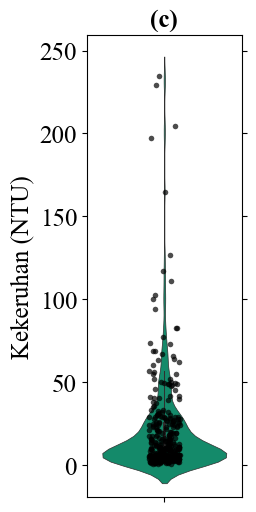

In [55]:
plt.figure(figsize=(2, 6))  # Perbesar ukuran gambar
sns.violinplot(y=data['Turbidity (NTU)'], color=okabe_ito_colors[2], linewidth=0.5, bw_adjust=0.6, width=0.8)

# Tambahkan strip plot untuk menampilkan sebaran titik-titik data
sns.stripplot(y=data['Turbidity (NTU)'], color='black', alpha=0.7, jitter=True, size=4)

# Menyesuaikan batas sumbu y agar mencakup nilai di bawah 0
min_value = data['Turbidity (NTU)'].min()
plt.ylim(min_value - 20, None)  # Tambahkan margin di bawah nilai minimum

# Menampilkan ticker di kedua sisi
plt.gca().yaxis.set_ticks_position('both')
plt.gca().tick_params(labelright=False)

# Menambahkan label dan judul
plt.ylabel("Kekeruhan (NTU)", fontname="Times New Roman", fontsize=18)
plt.title("(c)", fontname="Times New Roman", fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontname="Times New Roman")
plt.show()

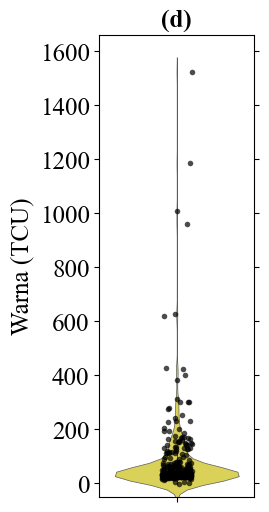

In [56]:
# Menampilkan data hanya untuk kolom 'Colour (TCU)'
plt.figure(figsize=(2, 6))  # Perbesar ukuran gambar
sns.violinplot(y=data['Colour (TCU)'], color=okabe_ito_colors[3], linewidth=0.5, bw_adjust=0.6, width=0.8)

# Tambahkan strip plot untuk menampilkan sebaran titik-titik data dengan jitter
sns.stripplot(y=data['Colour (TCU)'], color='black', alpha=0.7, jitter=True, size=4)

# Menyesuaikan batas sumbu y agar mencakup nilai di bawah 0
min_value = data['Colour (TCU)'].min()
plt.ylim(min_value - 50, None)  # Tambahkan margin di bawah nilai minimum

# Menampilkan ticker di kedua sisi
plt.gca().yaxis.set_ticks_position('both')
plt.gca().tick_params(labelright=False)

# Menambahkan label dan judul
plt.ylabel("Warna (TCU)", fontname="Times New Roman", fontsize=18)
plt.title("(d)", fontname="Times New Roman", fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontname="Times New Roman")
plt.show()

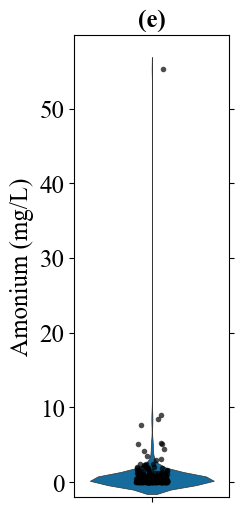

In [57]:
# Plot violin plot untuk variabel Ammonium (mg/L) dalam orientasi vertikal
plt.figure(figsize=(2, 6))
sns.violinplot(y=data['Ammonium (mg/L)'], color=okabe_ito_colors[4], linewidth=0.5, bw_adjust=0.8, width=0.8)

# Tambahkan scatter plot untuk menampilkan titik-titik data
sns.stripplot(y=data['Ammonium (mg/L)'], color='black', alpha=0.7, jitter=True, size=4)

#menyesuaikan batas sumbu y agar mencakup nilai di bawah 0
min_value = data['Ammonium (mg/L)'].min()
plt.ylim(min_value - 2, None)  # Tambahkan margin di bawah nilai minimum

plt.gca().yaxis.set_ticks_position('both')  # Menampilkan ticker di kedua sisi
plt.gca().tick_params(labelright=False)  # Menonaktifkan label angka di sisi kanan

# Menambahkan label dan judul
plt.ylabel("Amonium (mg/L)", fontname="Times New Roman", fontsize=18)
plt.title("(e)", fontname="Times New Roman", fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontname="Times New Roman")
plt.show()

## SELEKSI DATA OUTLIER

In [58]:
from sklearn.ensemble import IsolationForest

# Fungsi untuk menangani outlier menggunakan Isolation Forest
def handle_outliers_isolation_forest(df, contamination=0.1, random_state=42):
    """
    Menghapus outlier dari dataframe menggunakan Isolation Forest.
    
    Parameters:
    df (pd.DataFrame): Dataframe input
    contamination (float): Proporsi data yang dianggap sebagai outlier (default: 0.1)
    random_state (int): Seed untuk memastikan hasil yang konsisten (default: 42)
    
    Returns:
    pd.DataFrame: Dataframe tanpa outlier
    """
    # Salin dataframe untuk menghindari perubahan pada data asli
    df_cleaned = df.copy()
    
    # Inisialisasi Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    
    # Fit model dan prediksi label (-1 untuk outlier, 1 untuk inlier)
    outlier_labels = iso_forest.fit_predict(df_cleaned.select_dtypes(include=[np.number]))
    
    # Filter data berdasarkan label inlier
    df_cleaned = df_cleaned[outlier_labels == 1]
    
    return df_cleaned

# Terapkan fungsi untuk menangani outlier pada data
data_cleaned = handle_outliers_isolation_forest(data, contamination=0.1)

# Tampilkan informasi data setelah menangani outlier
print(f"Data sebelum menangani outlier: {data.shape}")
print(f"Data setelah menangani outlier: {data_cleaned.shape}")

Data sebelum menangani outlier: (337, 5)
Data setelah menangani outlier: (303, 5)


In [59]:
# Fungsi untuk menampilkan data yang diseleksi (inlier) dan outlier
def display_selected_data(data, data_cleaned):
    """
    Menampilkan indeks data yang diseleksi (inlier) dan yang dianggap sebagai outlier.
    
    Parameters:
    data (pd.DataFrame): Data asli sebelum seleksi
    data_cleaned (pd.DataFrame): Data setelah seleksi (inlier)
    """
    # Indeks data asli
    original_indices = set(data.index)
    
    # Indeks data yang diseleksi (inlier)
    selected_indices = set(data_cleaned.index)
    
    # Indeks data yang dianggap sebagai outlier
    outlier_indices = original_indices - selected_indices
    
    print("Indeks data yang diseleksi (inlier):")
    print(sorted(selected_indices))
    print("\nIndeks data yang dianggap sebagai outlier:")
    print(sorted(outlier_indices))

# Contoh penggunaan
display_selected_data(data, data_cleaned)

Indeks data yang diseleksi (inlier):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

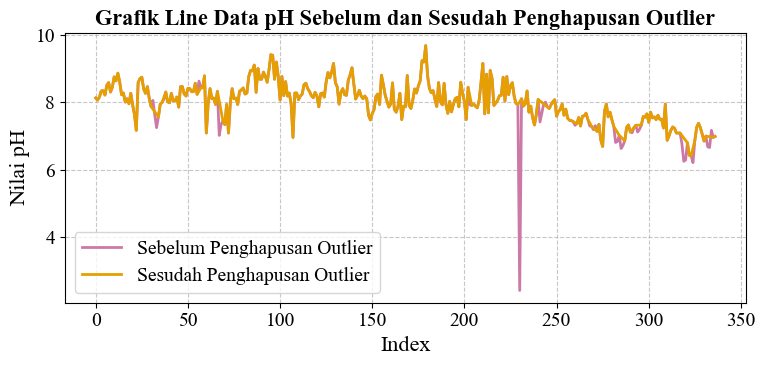

In [60]:
# Membuat grafik garis untuk data pH sebelum dan sesudah penghapusan outlier
plt.figure(figsize=(8, 4), dpi=100)

# Plot data pH sebelum penghapusan outlier
plt.plot(data.index, data['pH'], label='Sebelum Penghapusan Outlier', color=okabe_ito_colors[6], linewidth=2)

# Plot data pH sesudah penghapusan outlier
plt.plot(data_cleaned.index, data_cleaned['pH'], label='Sesudah Penghapusan Outlier', color=okabe_ito_colors[0], linewidth=2)

# Menambahkan label dan judul
plt.xlabel("Index", fontname="Times New Roman", fontsize=16)
plt.ylabel("Nilai pH", fontname="Times New Roman", fontsize=16)
plt.title("Grafik Line Data pH Sebelum dan Sesudah Penghapusan Outlier", fontname="Times New Roman", fontsize=16, fontweight='bold')

# Styling tick labels
plt.xticks(fontsize=14, fontname="Times New Roman")
plt.yticks(fontsize=14, fontname="Times New Roman")

# Menampilkan legenda
plt.legend(fontsize=14, loc='lower left', frameon=True)

# Menampilkan grid
plt.grid(linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

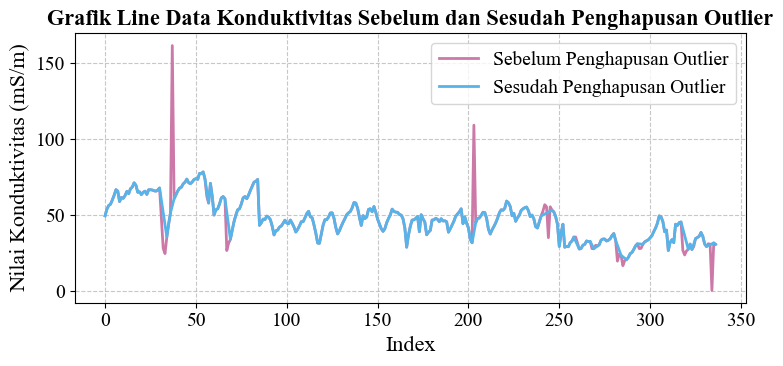

In [61]:
# Membuat grafik garis untuk data Konduktivitas sebelum dan sesudah penghapusan outlier
plt.figure(figsize=(8, 4), dpi=100)

# Plot data Konduktivitas sebelum penghapusan outlier
plt.plot(data.index, data['Conductivity (mS/m)'], label='Sebelum Penghapusan Outlier', color=okabe_ito_colors[6], linewidth=2)

# Plot data Konduktivitas sesudah penghapusan outlier
plt.plot(data_cleaned.index, data_cleaned['Conductivity (mS/m)'], label='Sesudah Penghapusan Outlier', color=okabe_ito_colors[1], linewidth=2)

# Menambahkan label dan judul
plt.xlabel("Index", fontname="Times New Roman", fontsize=16)
plt.ylabel("Nilai Konduktivitas (mS/m)", fontname="Times New Roman", fontsize=16)
plt.title("Grafik Line Data Konduktivitas Sebelum dan Sesudah Penghapusan Outlier", fontname="Times New Roman", fontsize=16, fontweight='bold')

# Styling tick labels
plt.xticks(fontsize=14, fontname="Times New Roman")
plt.yticks(fontsize=14, fontname="Times New Roman")

# Menampilkan legenda
plt.legend(fontsize=14, loc='upper right', frameon=True)

# Menampilkan grid
plt.grid(linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

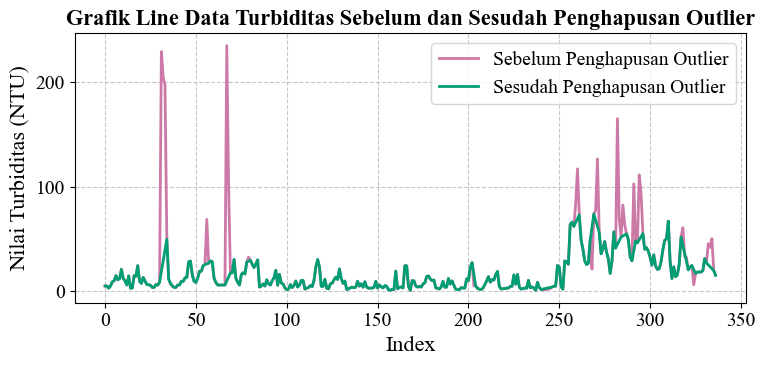

In [62]:
# Membuat grafik garis untuk data Turbiditas sebelum dan sesudah penghapusan outlier
plt.figure(figsize=(8, 4), dpi=100)

# Plot data Turbiditas sebelum penghapusan outlier
plt.plot(data.index, data['Turbidity (NTU)'], label='Sebelum Penghapusan Outlier', color=okabe_ito_colors[6], linewidth=2)

# Plot data Turbiditas sesudah penghapusan outlier
plt.plot(data_cleaned.index, data_cleaned['Turbidity (NTU)'], label='Sesudah Penghapusan Outlier', color=okabe_ito_colors[2], linewidth=2)

# Menambahkan label dan judul
plt.xlabel("Index", fontname="Times New Roman", fontsize=16)
plt.ylabel("Nilai Turbiditas (NTU)", fontname="Times New Roman", fontsize=16)
plt.title("Grafik Line Data Turbiditas Sebelum dan Sesudah Penghapusan Outlier", fontname="Times New Roman", fontsize=16, fontweight='bold')

# Styling tick labels
plt.xticks(fontsize=14, fontname="Times New Roman")
plt.yticks(fontsize=14, fontname="Times New Roman")

# Menampilkan legenda
plt.legend(fontsize=14, loc='upper right', frameon=True)

# Menampilkan grid
plt.grid(linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

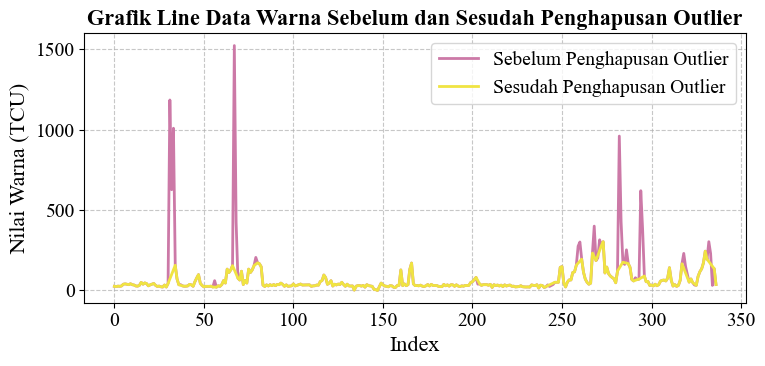

In [63]:
# Membuat grafik garis untuk data Warna sebelum dan sesudah penghapusan outlier
plt.figure(figsize=(8, 4), dpi=100)

# Plot data Warna sebelum penghapusan outlier
plt.plot(data.index, data['Colour (TCU)'], label='Sebelum Penghapusan Outlier', color=okabe_ito_colors[6], linewidth=2)

# Plot data Warna sesudah penghapusan outlier
plt.plot(data_cleaned.index, data_cleaned['Colour (TCU)'], label='Sesudah Penghapusan Outlier', color=okabe_ito_colors[3], linewidth=2)

# Menambahkan label dan judul
plt.xlabel("Index", fontname="Times New Roman", fontsize=16)
plt.ylabel("Nilai Warna (TCU)", fontname="Times New Roman", fontsize=16)
plt.title("Grafik Line Data Warna Sebelum dan Sesudah Penghapusan Outlier", fontname="Times New Roman", fontsize=16, fontweight='bold')

# Styling tick labels
plt.xticks(fontsize=14, fontname="Times New Roman")
plt.yticks(fontsize=14, fontname="Times New Roman")

# Menampilkan legenda
plt.legend(fontsize=14, loc='upper right', frameon=True)

# Menampilkan grid
plt.grid(linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

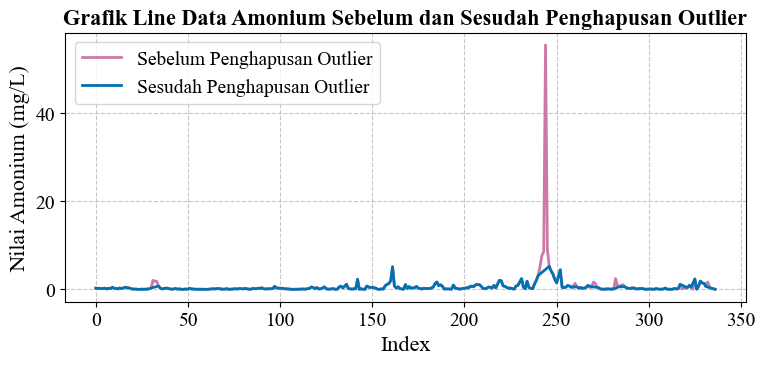

In [64]:
# Membuat grafik garis untuk data Amonium sebelum dan sesudah penghapusan outlier
plt.figure(figsize=(8, 4), dpi=100)

# Plot data Amonium sebelum penghapusan outlier
plt.plot(data.index, data['Ammonium (mg/L)'], label='Sebelum Penghapusan Outlier', color=okabe_ito_colors[6], linewidth=2)

# Plot data Amonium sesudah penghapusan outlier
plt.plot(data_cleaned.index, data_cleaned['Ammonium (mg/L)'], label='Sesudah Penghapusan Outlier', color=okabe_ito_colors[4], linewidth=2)

# Menambahkan label dan judul
plt.xlabel("Index", fontname="Times New Roman", fontsize=16)
plt.ylabel("Nilai Amonium (mg/L)", fontname="Times New Roman", fontsize=16)
plt.title("Grafik Line Data Amonium Sebelum dan Sesudah Penghapusan Outlier", fontname="Times New Roman", fontsize=16, fontweight='bold')

# Styling tick labels
plt.xticks(fontsize=14, fontname="Times New Roman")
plt.yticks(fontsize=14, fontname="Times New Roman")

# Menampilkan legenda
plt.legend(fontsize=14, loc='upper left', frameon=True)

# Menampilkan grid
plt.grid(linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

## Split Data & Fiture Engineering

In [65]:
# Menentukan variabel independen (X) dan dependen (Y) menggunakan data yang sudah diseleksi
X = data_cleaned[['pH', 'Conductivity (mS/m)', 'Turbidity (NTU)', 'Colour (TCU)']]
y = data_cleaned['Ammonium (mg/L)']

# Split Data: 80% Train - 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi menggunakan StandardScaler (untuk linier regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training

In [66]:
# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Model 2: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Model 3: XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [67]:
#Fungsi untuk menghitung Metrik Evaluasi untuk Model Regresi
#R², RMSE, Bias, RPD, and MAE.
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    bias = np.mean(y_pred - y_true)
    rpd = np.std(y_true) / rmse if rmse != 0 else np.inf
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, bias, rpd, mae

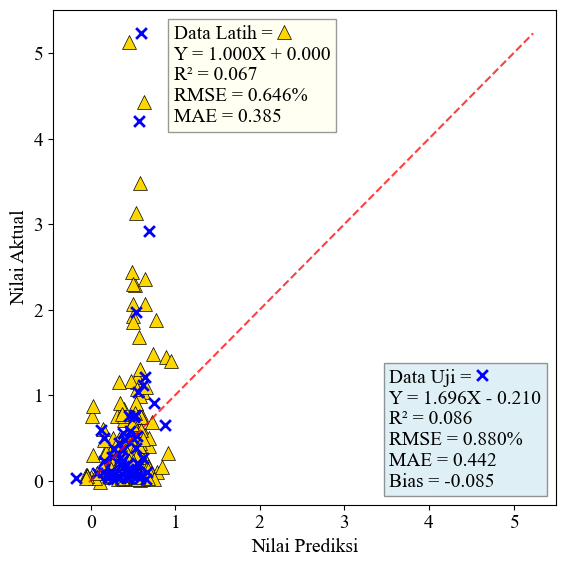

In [68]:
#Fungsi untuk menampilkan nilai aktual dan prediksi pada data training dan testing untuk model Linear Regression.
def plot_linear_regression(y_train, y_train_pred, y_test, y_test_pred):
    """
    Membuat plot scatter untuk membandingkan nilai aktual dan prediksi
    pada data training dan testing untuk model Linear Regression.
    """
    # Hitung koefisien regresi linear
    a_train, b_train = np.polyfit(y_train_pred, y_train, 1)
    a_test, b_test = np.polyfit(y_test_pred, y_test, 1)

    # Hitung metrik evaluasi
    r2_train, rmse_train, bias_train, rpd_train, mae_train = calculate_metrics(y_train, y_train_pred)
    r2_test, rmse_test, bias_test, rpd_test, mae_test = calculate_metrics(y_test, y_test_pred)

    # Inisialisasi plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

    # Plot data training dan testing
    ax.scatter(y_train_pred, y_train, facecolors='gold', edgecolors='black',
               marker='^', s=100, linewidths=0.5, label='Training')
    ax.scatter(y_test_pred, y_test, color='blue', marker='x',
               s=60, linewidths=2, label='Testing')

    # Garis referensi Y=X
    lims = [min(min(y_train), min(y_test)), max(max(y_train), max(y_test))]
    ax.plot(lims, lims, 'r--', alpha=0.75)

    # Teks dan posisi box
    # Posisi untuk kotak teks Training (kiri atas)
    train_x = lims[0] + 1
    train_y = lims[1] + 0.1

    # Posisi untuk kotak teks Testing (kanan bawah)
    test_x = lims[1] - 1.7
    test_y = lims[0] - 0.1

    # Tambahkan scatter dummy sebagai simbol di dekat teks Training
    ax.scatter(train_x + 1.3, train_y - 0.09, facecolors='gold', edgecolors='black',
               marker='^', s=100, linewidths=0.5, zorder=5)

    # Tambahkan scatter dummy sebagai simbol di dekat teks Testing
    ax.scatter(test_x + 1.1, test_y + 1.35, color='blue',
               marker='x', s=60, linewidths=2, zorder=5)

    # Teks Training
    training_text = (
        f"Data Latih =\n"
        f"Y = {a_train:.3f}X {'-' if b_train < 0 else '+'} {abs(b_train):.3f}\n"
        f"R² = {r2_train:.3f}\n"
        f"RMSE = {rmse_train:.3f}%\n"
        f"MAE = {mae_train:.3f}"
    )
    ax.text(train_x, train_y, training_text,
            fontsize=14, va='top', ha='left',
            bbox=dict(facecolor='lightyellow', alpha=0.4))

    # Teks Testing
    testing_text = (
        f"Data Uji =\n"
        f"Y = {a_test:.3f}X {'-' if b_test < 0 else '+'} {abs(b_test):.3f}\n"
        f"R² = {r2_test:.3f}\n"
        f"RMSE = {rmse_test:.3f}%\n"
        f"MAE = {mae_test:.3f}\n"
        f"Bias = {bias_test:.3f}"
        #f"RPD = {rpd_test:.3f}"
    )
    ax.text(test_x, test_y, testing_text,
            fontsize=14, va='bottom', ha='left',
            #fontstyle='italic',  # Membuat teks miring
            bbox=dict(facecolor='lightblue', alpha=0.4))

    # Label sumbu dan dekorasi
    ax.set_xlabel("Nilai Prediksi", fontsize=14)
    ax.set_ylabel("Nilai Aktual", fontsize=14)
    #ax.set_title("(a)", fontsize=14, fontweight='bold')
    #ax.grid(True, linestyle='--', alpha=0.6)
    #ax.legend(fontsize=12)
    
    # Styling tick labels
    plt.xticks(fontsize=14, fontname="Times New Roman")
    plt.yticks(fontsize=14, fontname="Times New Roman")

    plt.tight_layout()
    plt.show()

# Linear Regression
# Prediksi data training dan testing menggunakan model Linear Regression
y_train_pred_lr = lr.predict(X_train_scaled)
y_test_pred_lr = lr.predict(X_test_scaled)

# Plot hasil prediksi Linear Regression
plot_linear_regression(y_train, y_train_pred_lr, y_test, y_test_pred_lr)


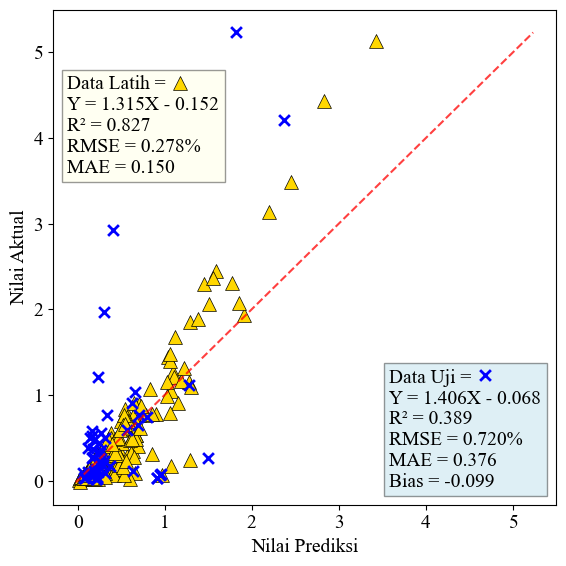

In [69]:
#Fungsi untuk menampilkan nilai aktual dan prediksi pada data training dan testing untuk model Random Forest Regressor.
def plot_random_forest(y_train, y_train_pred, y_test, y_test_pred):
    # Hitung koefisien
    a_train, b_train = np.polyfit(y_train_pred, y_train, 1)
    a_test, b_test = np.polyfit(y_test_pred, y_test, 1)

    # Hitung metrik evaluasi
    r2_train, rmse_train, bias_train, rpd_train, mae_train = calculate_metrics(y_train, y_train_pred)
    r2_test, rmse_test, bias_test, rpd_test, mae_test = calculate_metrics(y_test, y_test_pred)

    # Inisialisasi plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

    # Plot data training dan testing
    ax.scatter(y_train_pred, y_train, facecolors='gold', edgecolors='black',
               marker='^', s=100, linewidths=0.5, label='Training')
    ax.scatter(y_test_pred, y_test, color='blue', marker='x',
               s=60, linewidths=2, label='Testing')

    # Garis referensi Y=X
    lims = [min(min(y_train), min(y_test)), max(max(y_train), max(y_test))]
    ax.plot(lims, lims, 'r--', alpha=0.75)

    # Teks dan posisi box
    # Posisi untuk kotak teks Training (kiri atas)
    train_x = lims[0] - 0.1
    train_y = lims[1] - 0.5
    
    # Posisi untuk kotak teks Testing (kanan bawah)
    test_x = lims[1] - 1.65
    test_y = lims[0] - 0.1
    
    # Tambahkan scatter dummy sebagai simbol di dekat teks Training
    ax.scatter(train_x + 1.3, train_y - 0.09, facecolors='gold', edgecolors='black',
               marker='^', s=100, linewidths=0.5, zorder=5)

    # Tambahkan scatter dummy sebagai simbol di dekat teks Testing
    ax.scatter(test_x + 1.1, test_y + 1.35, color='blue',
               marker='x', s=60, linewidths=2, zorder=5)

    # Teks Training
    training_text = (
        f"Data Latih =\n"
        f"Y = {a_train:.3f}X {'-' if b_train < 0 else '+'} {abs(b_train):.3f}\n"
        f"R² = {r2_train:.3f}\n"
        f"RMSE = {rmse_train:.3f}%\n"
        f"MAE = {mae_train:.3f}"
    )
    ax.text(train_x, train_y, training_text,
            fontsize=14, va='top', ha='left',
            bbox=dict(facecolor='lightyellow', alpha=0.4))

    # Teks Testing
    testing_text = (
        f"Data Uji =\n"
        f"Y = {a_test:.3f}X {'-' if b_test < 0 else '+'} {abs(b_test):.3f}\n"
        f"R² = {r2_test:.3f}\n"
        f"RMSE = {rmse_test:.3f}%\n"
        f"MAE = {mae_test:.3f}\n"
        f"Bias = {bias_test:.3f}"
        #f"RPD = {rpd_test:.3f}"
    )
    ax.text(test_x, test_y, testing_text,
            fontsize=14, va='bottom', ha='left',
            bbox=dict(facecolor='lightblue', alpha=0.4))

    # Label sumbu dan dekorasi
    ax.set_xlabel("Nilai Prediksi", fontsize=14)
    ax.set_ylabel("Nilai Aktual", fontsize=14)
    #ax.set_title("(b)", fontsize=14, fontweight='bold')
    #ax.grid(True, linestyle='--', alpha=0.6)
    #ax.legend(fontsize=12)
    
    # Styling tick labels
    plt.xticks(fontsize=14, fontname="Times New Roman")
    plt.yticks(fontsize=14, fontname="Times New Roman")

    plt.tight_layout()
    plt.show()

# Prediksi untuk data training dan testing (Random Forest)
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# Tampilkan grafik untuk Random Forest
plot_random_forest(y_train, y_train_pred_rf, y_test, y_test_pred_rf)


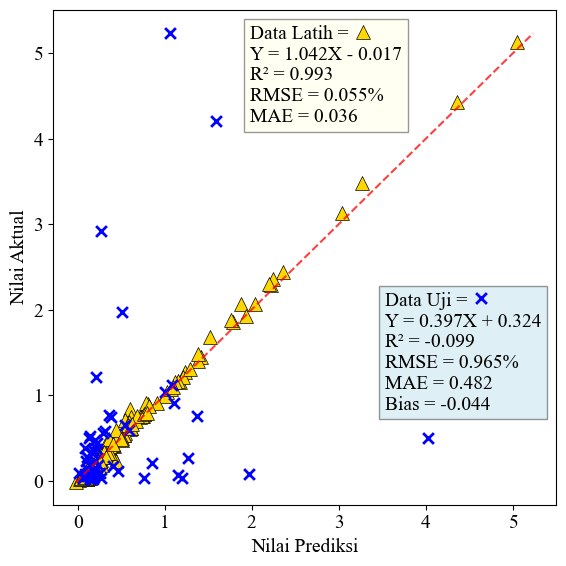

In [70]:
#Fungsi untuk menampilkan nilai aktual dan prediksi pada data training dan testing untuk model XGBoost Regressor.
def plot_xgboost(y_train, y_train_pred, y_test, y_test_pred):
    # Hitung koefisien
    a_train, b_train = np.polyfit(y_train_pred, y_train, 1)
    a_test, b_test = np.polyfit(y_test_pred, y_test, 1)

    # Hitung metrik evaluasi
    r2_train, rmse_train, bias_train, rpd_train, mae_train = calculate_metrics(y_train, y_train_pred)
    r2_test, rmse_test, bias_test, rpd_test, mae_test = calculate_metrics(y_test, y_test_pred)

    # Inisialisasi plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

    # Plot data training dan testing
    ax.scatter(y_train_pred, y_train, facecolors='gold', edgecolors='black',
               marker='^', s=100, linewidths=0.5, label='Training')
    ax.scatter(y_test_pred, y_test, color='blue', marker='x',
               s=60, linewidths=2, label='Testing')

    # Garis referensi Y=X
    lims = [min(min(y_train), min(y_test)), max(max(y_train), max(y_test))]
    ax.plot(lims, lims, 'r--', alpha=0.75)

    # Teks dan posisi box
    # Posisi untuk kotak teks Training (kiri atas)
    train_x = lims[0] + 2
    train_y = lims[1] + 0.1
    
    # Posisi untuk kotak teks Testing (kanan bawah)
    test_x = lims[1] - 1.7
    test_y = lims[0] + 0.8

    # Tambahkan scatter dummy sebagai simbol di dekat teks Training
    ax.scatter(train_x + 1.3, train_y - 0.09, facecolors='gold', edgecolors='black',
               marker='^', s=100, linewidths=0.5, zorder=5)

    # Tambahkan scatter dummy sebagai simbol di dekat teks Testing
    ax.scatter(test_x + 1.1, test_y + 1.35, color='blue',
               marker='x', s=60, linewidths=2, zorder=5)

    # Teks Training
    training_text = (
        f"Data Latih =\n"
        f"Y = {a_train:.3f}X {'-' if b_train < 0 else '+'} {abs(b_train):.3f}\n"
        f"R² = {r2_train:.3f}\n"
        f"RMSE = {rmse_train:.3f}%\n"
        f"MAE = {mae_train:.3f}"
    )
    ax.text(train_x, train_y, training_text,
            fontsize=14, va='top', ha='left',
            bbox=dict(facecolor='lightyellow', alpha=0.4))

    # Teks Testing
    testing_text = (
        f"Data Uji =\n"
        f"Y = {a_test:.3f}X {'-' if b_test < 0 else '+'} {abs(b_test):.3f}\n"
        f"R² = {r2_test:.3f}\n"
        f"RMSE = {rmse_test:.3f}%\n"
        f"MAE = {mae_test:.3f}\n"
        f"Bias = {bias_test:.3f}"
        #f"RPD = {rpd_test:.3f}"
    )
    ax.text(test_x, test_y, testing_text,
            fontsize=14, va='bottom', ha='left',
            bbox=dict(facecolor='lightblue', alpha=0.4))

    # Label sumbu dan dekorasi
    ax.set_xlabel("Nilai Prediksi", fontsize=14)
    ax.set_ylabel("Nilai Aktual", fontsize=14)
    #ax.set_title("(c)", fontsize=14, fontweight='bold')
    #ax.grid(True, linestyle='--', alpha=0.6)
    #ax.legend(fontsize=12)
    
    # Styling tick labels
    plt.xticks(fontsize=14, fontname="Times New Roman")
    plt.yticks(fontsize=14, fontname="Times New Roman")

    plt.tight_layout()
    plt.show()

# Prediksi untuk data training dan testing (XGBoost)
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

# Tampilkan grafik untuk XGBoost
plot_xgboost(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb)


## Evaluasi Model
MAE (Mean Absolute Error) → Rata-rata kesalahan absolut. <br>
RMSE (Root Mean Squared Error) → Metrik yang lebih sensitif terhadap outlier.<br>
R² Score (Koefisien Determinasi) → Mengukur seberapa baik model menjelaskan variabilitas data (nilai mendekati 1 lebih baik).<br>

In [71]:
# Fungsi Evaluasi Model
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluasi Model: {model_name}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.3f}")  # Perbaikan
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}\n")

# Contoh penggunaan
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")


Evaluasi Model: Linear Regression
MAE: 0.442
RMSE: 0.880
R² Score: 0.086

Evaluasi Model: Random Forest
MAE: 0.376
RMSE: 0.720
R² Score: 0.389

Evaluasi Model: XGBoost
MAE: 0.482
RMSE: 0.965
R² Score: -0.099



In [72]:
# Buat fungsi untuk visualisasi model
# Simpan hasil evaluasi ke dalam dictionary
model_scores = {}

# Fungsi Evaluasi Model (Memasukkan hasil ke dictionary)
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    model_scores[model_name] = {"MAE": mae, "RMSE": rmse, "R² Score": r2}
    
# Evaluasi semua model
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Konversi ke DataFrame untuk plotting
df_scores = pd.DataFrame(model_scores).T  # Transpose agar model jadi sumbu X

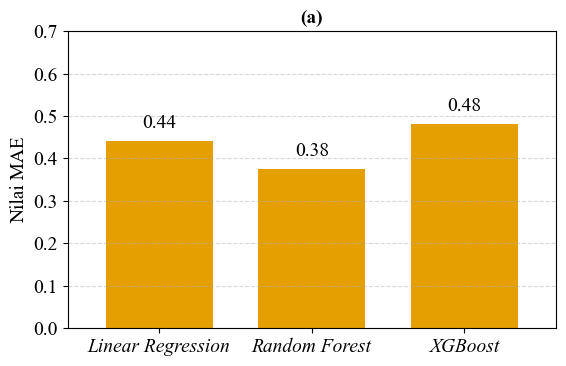

In [73]:
def visualize_mae(model_scores, tick_step=0.1):
    # Konversi dictionary ke DataFrame
    df_scores = pd.DataFrame(model_scores).T  # Transpose agar model jadi sumbu X
    
    # Plot MAE
    plt.figure(figsize=(6, 4), dpi=100)
    df_scores["MAE"].plot(kind='bar', color=okabe_ito_colors[0], edgecolor=None, width=0.7)
    plt.title("(a)", fontname="Times New Roman", fontsize=14, fontweight='bold')
    plt.ylabel("Nilai MAE", fontname="Times New Roman", fontsize=14)
    
    # Atur nilai ticker pada sumbu y
    max_value = 0.7
    plt.yticks(np.arange(0, max_value + tick_step, tick_step), fontsize=14, fontname="Times New Roman")
    
    # Tambahkan nilai di atas batang
    for index, value in enumerate(df_scores["MAE"]):
        plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=14, fontname='Times New Roman')

    # Tambahkan grid horizontal
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Modifikasi nama model menjadi italic
    plt.xticks(fontsize=14, fontname="Times New Roman", rotation=0, fontstyle='italic')
    
    # Tampilkan plot
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
visualize_mae(model_scores, tick_step=0.1)


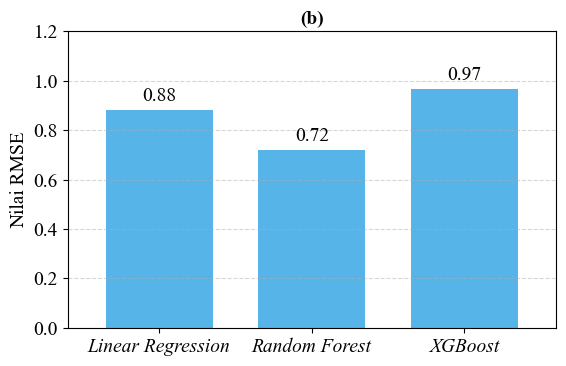

In [74]:
def visualize_rmse(model_scores, tick_step=0.1):
    # Konversi dictionary ke DataFrame
    df_scores = pd.DataFrame(model_scores).T  # Transpose agar model jadi sumbu X
    
    # Plot RMSE
    plt.figure(figsize=(6, 4), dpi=100)
    df_scores["RMSE"].plot(kind='bar', color=okabe_ito_colors[1], edgecolor=None, width=0.7)
    plt.title("(b)", fontname="Times New Roman", fontsize=14, fontweight='bold')
    plt.ylabel("Nilai RMSE", fontname="Times New Roman", fontsize=14)
    
    # Atur nilai ticker pada sumbu y
    max_value = df_scores["RMSE"].max() + 0.1
    plt.yticks(np.arange(0, max_value + tick_step, tick_step), fontsize=14, fontname="Times New Roman")
    
    # Tambahkan nilai di atas batang
    for index, value in enumerate(df_scores["RMSE"]):
        plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=14, fontname='Times New Roman')

    # Tambahkan grid horizontal
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Modifikasi nama model menjadi italic
    plt.xticks(fontsize=14, fontname="Times New Roman", rotation=0, fontstyle='italic')
    
    # Tampilkan plot
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
visualize_rmse(model_scores, tick_step=0.2)


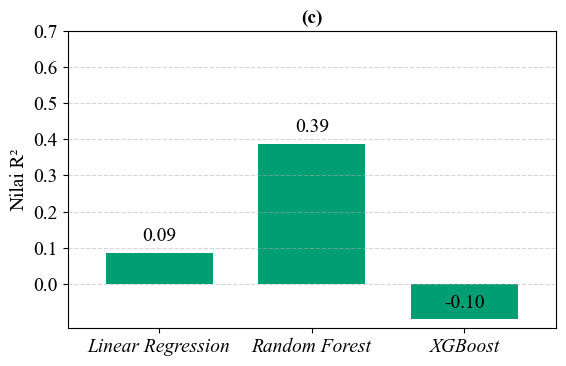

In [75]:
def visualize_r2(model_scores, tick_step=0.1):
    # Konversi dictionary ke DataFrame
    df_scores = pd.DataFrame(model_scores).T  # Transpose agar model jadi sumbu X
    
    # Plot R² Score
    plt.figure(figsize=(6, 4), dpi=100)
    df_scores["R² Score"].plot(kind='bar', color=okabe_ito_colors[2], edgecolor=None, width=0.7)
    plt.title("(c)", fontname="Times New Roman", fontsize=14, fontweight='bold')
    plt.ylabel("Nilai R²", fontname="Times New Roman", fontsize=14)
    
    # Atur nilai ticker pada sumbu y
    max_value = 0.7
    plt.yticks(np.arange(0, max_value + tick_step, tick_step), fontsize=14, fontname="Times New Roman")
        
    # Tambahkan nilai di atas batang
    for index, value in enumerate(df_scores["R² Score"]):
        plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=14, fontname='Times New Roman')

    # Tambahkan grid horizontal
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Modifikasi nama model menjadi italic
    plt.xticks(fontsize=14, fontname="Times New Roman", rotation=0, fontstyle='italic')
    
    # Tampilkan plot
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
visualize_r2(model_scores, tick_step=0.1)


<p>📊 <strong data-start="2027" data-end="2104">Grafik akan menampilkan perbandingan MAE, RMSE, dan R&sup2; untuk setiap model</strong>.<br data-start="2105" data-end="2108" />✔ <strong data-start="2110" data-end="2165">Semakin rendah MAE dan RMSE &rarr; semakin baik modelnya</strong><br data-start="2165" data-end="2168" />✔ <strong data-start="2170" data-end="2221">Semakin tinggi R&sup2; Score &rarr; semakin baik modelnya</strong></p>

## Interpretasi Model (Feature Importance)

Menampilkan variabel mana yang paling berpengaruh dalam prediksi model.

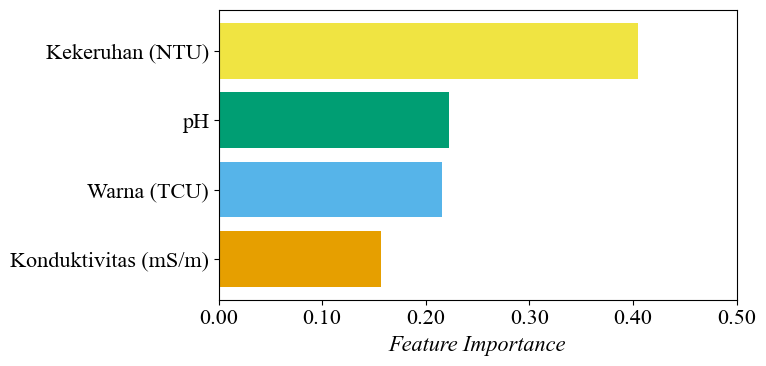

In [76]:
from matplotlib.ticker import FormatStrFormatter

# Feature Importance dari model Random Forest Regressor
importances = rf.feature_importances_  # Menggunakan model Random Forest
sorted_idx = np.argsort(importances)

# Gunakan label yang sudah diterjemahkan
translated_feature_names = [variable_translation[var] for var in X.columns]

# Membuat warna menggunakan palet warna Okabe-Ito
colors = [okabe_ito_colors[i % len(okabe_ito_colors)] for i in range(len(importances))]

# Parameter untuk mengatur range ticker bawah dan atas
tick_min = 0.0  # Anda dapat mengatur nilai ini sesuai kebutuhan
tick_max = 0.5  # Anda dapat mengatur nilai ini sesuai kebutuhan

# Plot dengan Matplotlib
plt.figure(figsize=(8, 4))
plt.barh([translated_feature_names[i] for i in sorted_idx], importances[sorted_idx], color=colors)
plt.xlabel("Feature Importance", fontname="Times New Roman", fontsize=16, fontstyle='italic')

# Atur xticks dengan format 2 desimal dan range bawah serta atas
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().set_xlim(left=tick_min, right=tick_max)

plt.xticks(fontsize=16, fontname="Times New Roman")
plt.yticks(fontsize=16, fontname="Times New Roman")
#plt.title("Feature Importance - Random Forest", fontname="Times New Roman", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()